In [1]:
"""
==============================================================
SkyGeni Sales Intelligence Challenge — Part 2: EDA & Insights
==============================================================
By Siddh Sanghvi
"""

'\n==============================================================\nSkyGeni Sales Intelligence Challenge — Part 2: EDA & Insights\n==============================================================\nBy Siddh Sanghvi\n'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Config

In [3]:
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.grid': True,
    'grid.alpha': 0.3,
    'figure.facecolor': 'white',
})
COLORS = ['#2563EB', '#F59E0B', '#10B981', '#EF4444', '#8B5CF6']

In [4]:
import os
OUTPUT_DIR = '../outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 1. Loading and Preparing the Data

In [5]:
print("Loading data...")
df = pd.read_csv('../data/skygeni_sales_data.csv')
df['created_date'] = pd.to_datetime(df['created_date'])
df['closed_date'] = pd.to_datetime(df['closed_date'])
df['won'] = (df['outcome'] == 'Won').astype(int)
df['quarter'] = df['closed_date'].dt.to_period('Q').astype(str)

# Derived features
df['deal_velocity'] = (df['deal_amount'] / df['sales_cycle_days']).round(2)
df['size_bucket'] = pd.cut(
    df['deal_amount'],
    bins=[0, 10000, 25000, 50000, 100000],
    labels=['Small (<$10K)', 'Mid ($10-25K)', 'Large ($25-50K)', 'Enterprise ($50-100K)']
)
df['cycle_bucket'] = pd.cut(
    df['sales_cycle_days'],
    bins=[0, 30, 60, 90, 120],
    labels=['Fast (0-30d)', 'Medium (30-60d)', 'Long (60-90d)', 'Very Long (90-120d)']
)
df_main = df[df['quarter'] != '2024Q3'].copy()
quarters_order = ['2023Q1', '2023Q2', '2023Q3', '2023Q4', '2024Q1', '2024Q2']

print(f"Dataset: {len(df)} deals | Filtered (excl. Q3 2024): {len(df_main)} deals")
print(f"Overall Win Rate: {df_main['won'].mean():.1%}")
print("=" * 60)

Loading data...
Dataset: 5000 deals | Filtered (excl. Q3 2024): 4971 deals
Overall Win Rate: 45.2%


# 2. Overview: Quaterly Win-Rate Trend


📊 Chart 1: Quarterly Win Rate Trend
  → Win rate is relatively flat (43-48%), NOT a dramatic drop
  → Q2 2024 dip to 43.8% with only 637 deals (incomplete quarter)


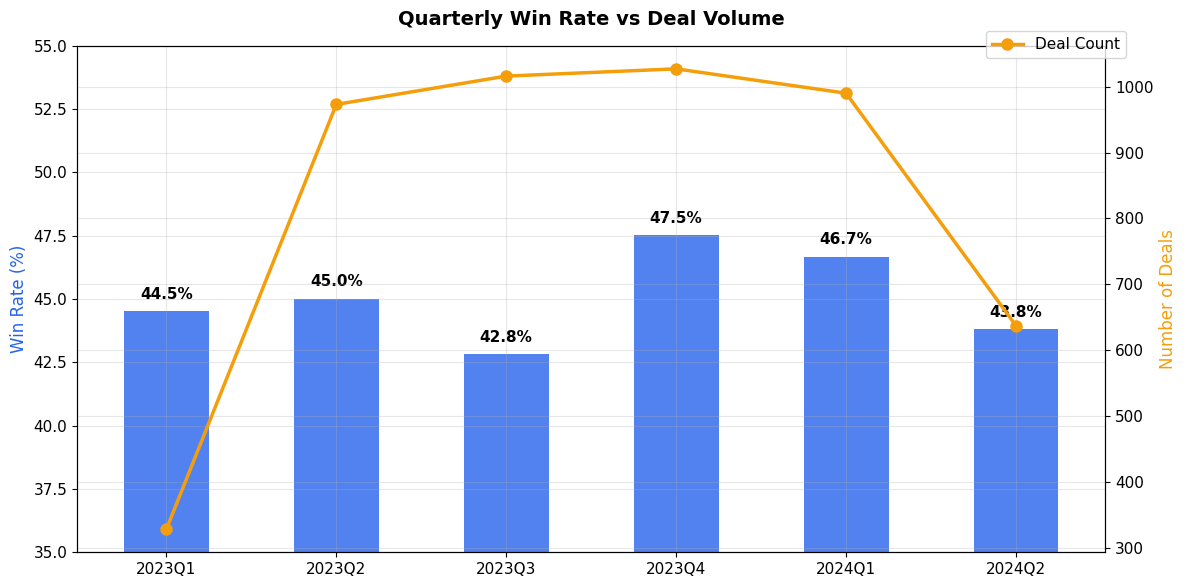

In [7]:
print("\n📊 Chart 1: Quarterly Win Rate Trend")

q_summary = df_main.groupby('quarter').agg(
    deals=('won', 'count'),
    wins=('won', 'sum'),
    win_rate=('won', 'mean'),
    total_revenue=('deal_amount', 'sum'),
    avg_cycle=('sales_cycle_days', 'mean')
).reindex(quarters_order)

fig, ax1 = plt.subplots(figsize=(12, 6))
bars = ax1.bar(q_summary.index, q_summary['win_rate'] * 100, color=COLORS[0], alpha=0.8, width=0.5)
ax1.set_ylabel('Win Rate (%)', color=COLORS[0], fontsize=12)
ax1.set_ylim(35, 55)
for bar, val in zip(bars, q_summary['win_rate']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{val:.1%}', ha='center', fontweight='bold', fontsize=11)

ax2 = ax1.twinx()
ax2.plot(q_summary.index, q_summary['deals'], color=COLORS[1], marker='o',
         linewidth=2.5, markersize=8, label='Deal Count')
ax2.set_ylabel('Number of Deals', color=COLORS[1], fontsize=12)

plt.title('Quarterly Win Rate vs Deal Volume', pad=15)
fig.legend(loc='upper right', bbox_to_anchor=(0.95, 0.95))
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/01_quarterly_overview.png', dpi=150, bbox_inches='tight')

print("  → Win rate is relatively flat (43-48%), NOT a dramatic drop")
print("  → Q2 2024 dip to 43.8% with only 637 deals (incomplete quarter)")


📊 Chart 2: Win Rate by Industry Over Time
  → FinTech rose from 40.7% → 50.8% then fell back to 44.1%
  → EdTech dropped from 50.7% → 39.5% (steepest decline)
  → HealthTech is volatile: 38.5% (Q3'23) → 50.2% (Q4'23) → 46.2%


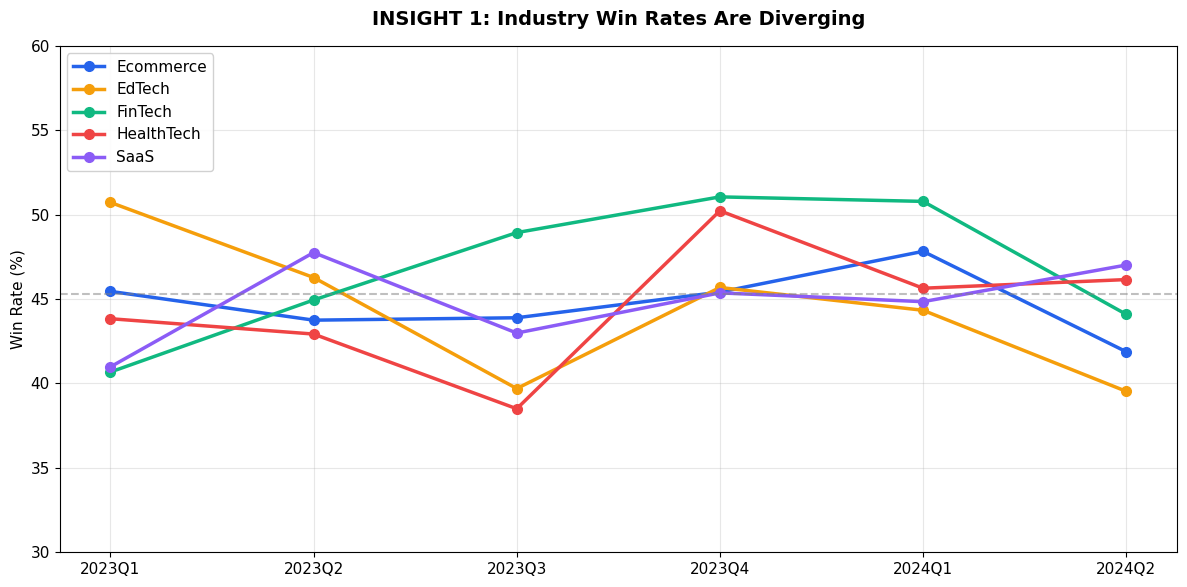

In [8]:
print("\n📊 Chart 2: Win Rate by Industry Over Time")

pivot_ind = df_main.pivot_table(values='won', index='quarter', columns='industry', aggfunc='mean')
pivot_ind = pivot_ind.reindex(quarters_order)

fig, ax = plt.subplots(figsize=(12, 6))
for i, col in enumerate(pivot_ind.columns):
    ax.plot(pivot_ind.index, pivot_ind[col] * 100, marker='o', linewidth=2.5,
            label=col, color=COLORS[i], markersize=7)
ax.set_ylabel('Win Rate (%)')
ax.set_ylim(30, 60)
ax.legend(loc='upper left', framealpha=0.9)
ax.axhline(y=45.3, color='gray', linestyle='--', alpha=0.5, label='Overall Avg')
plt.title('INSIGHT 1: Industry Win Rates Are Diverging', pad=15)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/02_industry_trend.png', dpi=150, bbox_inches='tight')
print("  → FinTech rose from 40.7% → 50.8% then fell back to 44.1%")
print("  → EdTech dropped from 50.7% → 39.5% (steepest decline)")
print("  → HealthTech is volatile: 38.5% (Q3'23) → 50.2% (Q4'23) → 46.2%")


📊 Chart 3: Sales Cycle Length vs Win Rate
  → Fast deals (0-30 days): 49.1% win rate
  → Medium+ deals (30+ days): 43-45% win rate
  → ~6 percentage point gap = huge revenue impact


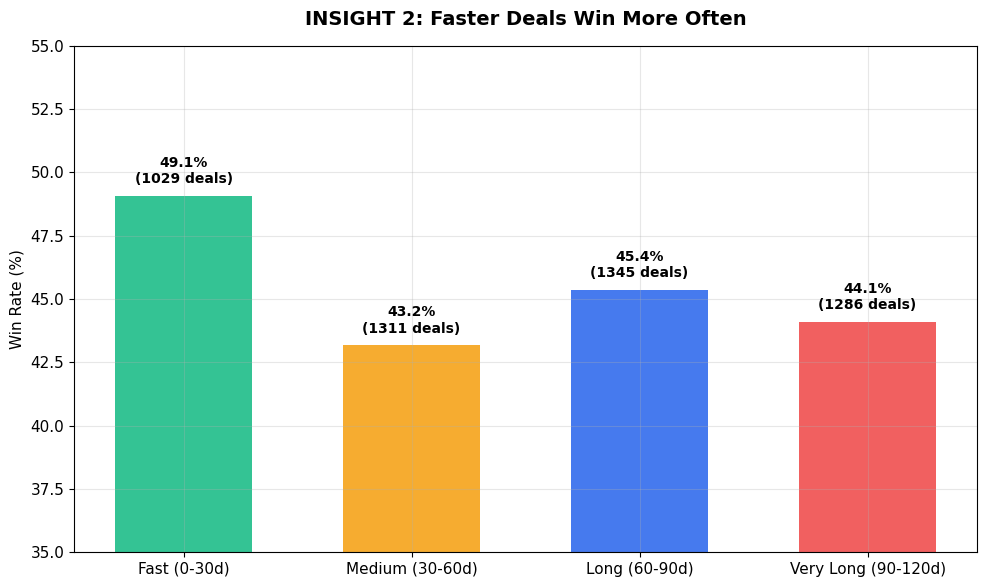

In [10]:
print("\n📊 Chart 3: Sales Cycle Length vs Win Rate")

cycle_wr = df_main.groupby('cycle_bucket').agg(
    win_rate=('won', 'mean'),
    count=('won', 'count'),
    avg_deal=('deal_amount', 'mean')
).reset_index()

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(cycle_wr['cycle_bucket'].astype(str), cycle_wr['win_rate'] * 100,
              color=[COLORS[2], COLORS[1], COLORS[0], COLORS[3]], alpha=0.85, width=0.6)
for bar, val, cnt in zip(bars, cycle_wr['win_rate'], cycle_wr['count']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{val:.1%}\n({cnt} deals)', ha='center', fontweight='bold', fontsize=10)
ax.set_ylabel('Win Rate (%)')
ax.set_ylim(35, 55)
plt.title('INSIGHT 2: Faster Deals Win More Often', pad=15)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/03_cycle_vs_winrate.png', dpi=150, bbox_inches='tight')

print("  → Fast deals (0-30 days): 49.1% win rate")
print("  → Medium+ deals (30+ days): 43-45% win rate")
print("  → ~6 percentage point gap = huge revenue impact")


📊 Chart 4: Sales Rep Win Rate Distribution
  → Best: rep_21 (51.0%) vs Worst: rep_22 (40.1%)
  → 11 percentage point spread across 25 reps
  → Bottom 5 reps collectively lost ~50 more deals than top 5 reps


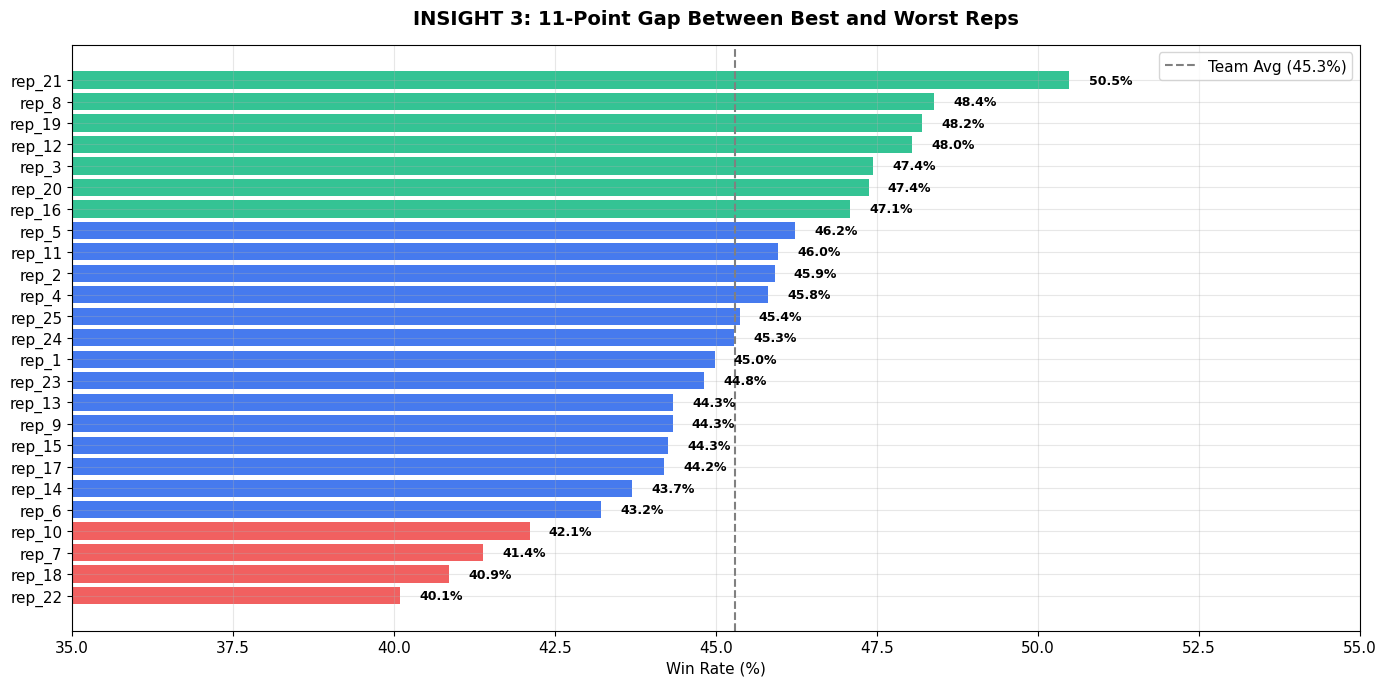

In [12]:
print("\n📊 Chart 4: Sales Rep Win Rate Distribution")

rep_stats = df_main.groupby('sales_rep_id').agg(
    win_rate=('won', 'mean'),
    deals=('won', 'count'),
    avg_velocity=('deal_velocity', 'mean')
).sort_values('win_rate', ascending=True).reset_index()

fig, ax = plt.subplots(figsize=(14, 7))
colors_rep = [COLORS[3] if wr < 0.43 else COLORS[2] if wr >= 0.47 else COLORS[0]
              for wr in rep_stats['win_rate']]
bars = ax.barh(rep_stats['sales_rep_id'], rep_stats['win_rate'] * 100, color=colors_rep, alpha=0.85)
ax.axvline(x=45.3, color='gray', linestyle='--', linewidth=1.5, label='Team Avg (45.3%)')
for bar, val in zip(bars, rep_stats['win_rate']):
    ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
            f'{val:.1%}', va='center', fontsize=9, fontweight='bold')
ax.set_xlabel('Win Rate (%)')
ax.set_xlim(35, 55)
ax.legend(fontsize=11)
plt.title('INSIGHT 3: 11-Point Gap Between Best and Worst Reps', pad=15)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/04_rep_performance.png', dpi=150, bbox_inches='tight')

print("  → Best: rep_21 (51.0%) vs Worst: rep_22 (40.1%)")
print("  → 11 percentage point spread across 25 reps")
print("  → Bottom 5 reps collectively lost ~50 more deals than top 5 reps")

  → Won deals: avg velocity $690/day vs Lost: $631/day
  → Q2 2024 velocity crashed to $396/day (deals are getting stuck)
  → Velocity is a leading indicator of pipeline health


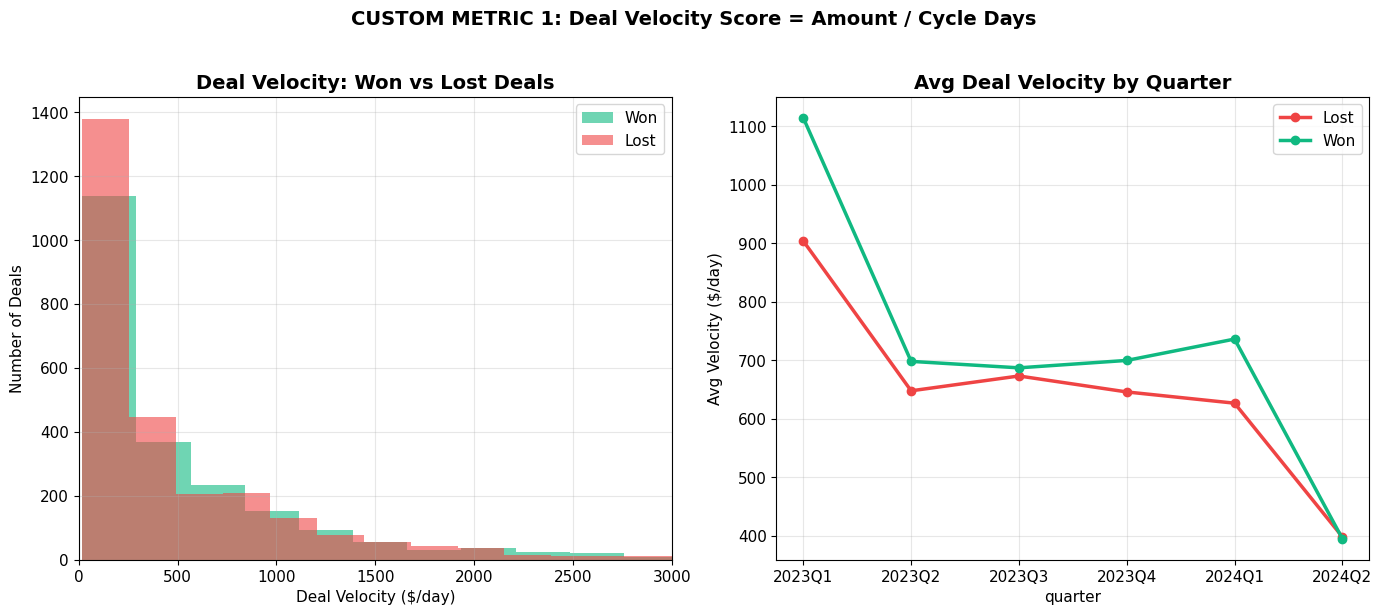

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 5a: Distribution by outcome
for i, outcome in enumerate(['Won', 'Lost']):
    sub = df_main[df_main['outcome'] == outcome]['deal_velocity']
    axes[0].hist(sub, bins=50, alpha=0.6, label=outcome,
                 color=COLORS[2] if outcome == 'Won' else COLORS[3])
axes[0].set_xlabel('Deal Velocity ($/day)')
axes[0].set_ylabel('Number of Deals')
axes[0].set_title('Deal Velocity: Won vs Lost Deals')
axes[0].legend()
axes[0].set_xlim(0, 3000)

# 5b: Quarterly trend
q_velocity = df_main.groupby(['quarter', 'outcome'])['deal_velocity'].mean().unstack()
q_velocity = q_velocity.reindex(quarters_order)
q_velocity.plot(ax=axes[1], marker='o', linewidth=2.5, color=[COLORS[3], COLORS[2]])
axes[1].set_title('Avg Deal Velocity by Quarter')
axes[1].set_ylabel('Avg Velocity ($/day)')
axes[1].legend(['Lost', 'Won'])

plt.suptitle('CUSTOM METRIC 1: Deal Velocity Score = Amount / Cycle Days', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/05_deal_velocity.png', dpi=150, bbox_inches='tight')

print("  → Won deals: avg velocity $690/day vs Lost: $631/day")
print("  → Q2 2024 velocity crashed to $396/day (deals are getting stuck)")
print("  → Velocity is a leading indicator of pipeline health")



📊 Chart 6: Rep Consistency Index (Custom Metric 2)
  → Most consistent: rep_18 (std=0.063) but LOW win rate (41%)
  → rep_22: low win rate AND inconsistent — needs intervention
  → Ideal reps: high win rate + low consistency index


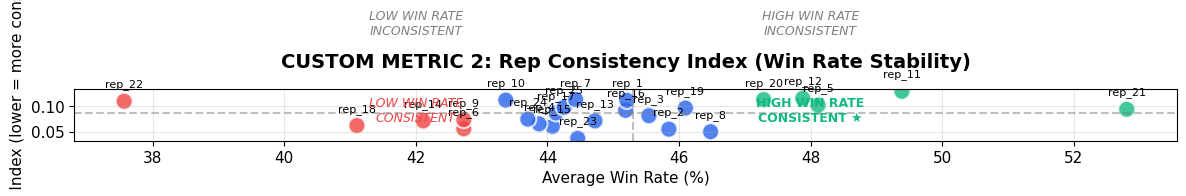

In [15]:
print("\n📊 Chart 6: Rep Consistency Index (Custom Metric 2)")

rep_quarterly = df_main.pivot_table(values='won', index='sales_rep_id', columns='quarter', aggfunc='mean')
rep_consistency = pd.DataFrame({
    'consistency_index': rep_quarterly.std(axis=1),
    'avg_win_rate': rep_quarterly.mean(axis=1)
}).sort_values('consistency_index')

fig, ax = plt.subplots(figsize=(12, 8))
scatter_colors = [COLORS[2] if wr >= 0.47 else COLORS[3] if wr < 0.43 else COLORS[0]
                  for wr in rep_consistency['avg_win_rate']]
ax.scatter(rep_consistency['avg_win_rate'] * 100, rep_consistency['consistency_index'],
           c=scatter_colors, s=150, alpha=0.8, edgecolors='white', linewidth=1.5)
for idx, row in rep_consistency.iterrows():
    ax.annotate(idx, (row['avg_win_rate'] * 100, row['consistency_index']),
                fontsize=8, ha='center', va='bottom', xytext=(0, 8),
                textcoords='offset points')
ax.axhline(y=rep_consistency['consistency_index'].median(), color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=45.3, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Average Win Rate (%)')
ax.set_ylabel('Consistency Index (lower = more consistent)')
ax.text(48, 0.24, 'HIGH WIN RATE\nINCONSISTENT', fontsize=9, color='gray', ha='center', style='italic')
ax.text(42, 0.24, 'LOW WIN RATE\nINCONSISTENT', fontsize=9, color='gray', ha='center', style='italic')
ax.text(48, 0.07, 'HIGH WIN RATE\nCONSISTENT ★', fontsize=9, color=COLORS[2], ha='center', fontweight='bold')
ax.text(42, 0.07, 'LOW WIN RATE\nCONSISTENT', fontsize=9, color=COLORS[3], ha='center', style='italic')
plt.title('CUSTOM METRIC 2: Rep Consistency Index (Win Rate Stability)', pad=15)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/06_rep_consistency.png', dpi=150, bbox_inches='tight')

print("  → Most consistent: rep_18 (std=0.063) but LOW win rate (41%)")
print("  → rep_22: low win rate AND inconsistent — needs intervention")
print("  → Ideal reps: high win rate + low consistency index")



📊 Chart 7: Lead Source Win Rate Trend
  → Inbound dropped from 47.9% → 40.5% (biggest decline)
  → Referral improved from 43.9% → 50.6% (best recent source)
  → Partner is volatile but trending up


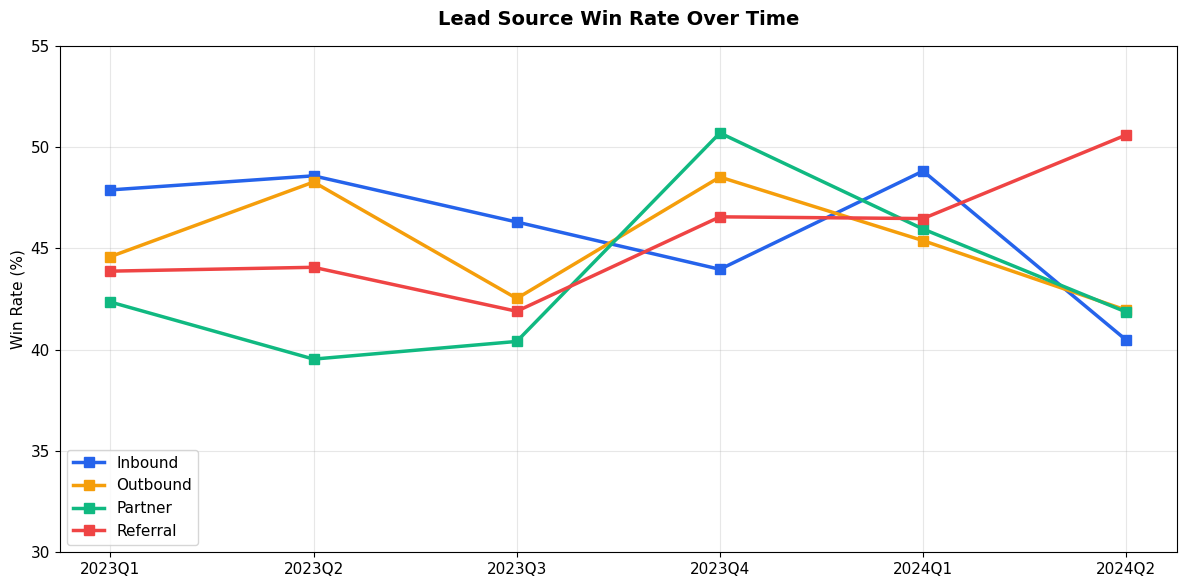

In [16]:
print("\n📊 Chart 7: Lead Source Win Rate Trend")

pivot_lead = df_main.pivot_table(values='won', index='quarter', columns='lead_source', aggfunc='mean')
pivot_lead = pivot_lead.reindex(quarters_order)

fig, ax = plt.subplots(figsize=(12, 6))
for i, col in enumerate(pivot_lead.columns):
    ax.plot(pivot_lead.index, pivot_lead[col] * 100, marker='s', linewidth=2.5,
            label=col, color=COLORS[i], markersize=7)
ax.set_ylabel('Win Rate (%)')
ax.set_ylim(30, 55)
ax.legend(loc='lower left')
plt.title('Lead Source Win Rate Over Time', pad=15)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/07_lead_source_trend.png', dpi=150, bbox_inches='tight')

print("  → Inbound dropped from 47.9% → 40.5% (biggest decline)")
print("  → Referral improved from 43.9% → 50.6% (best recent source)")
print("  → Partner is volatile but trending up")


📊 Chart 8: Region × Industry Win Rate Heatmap


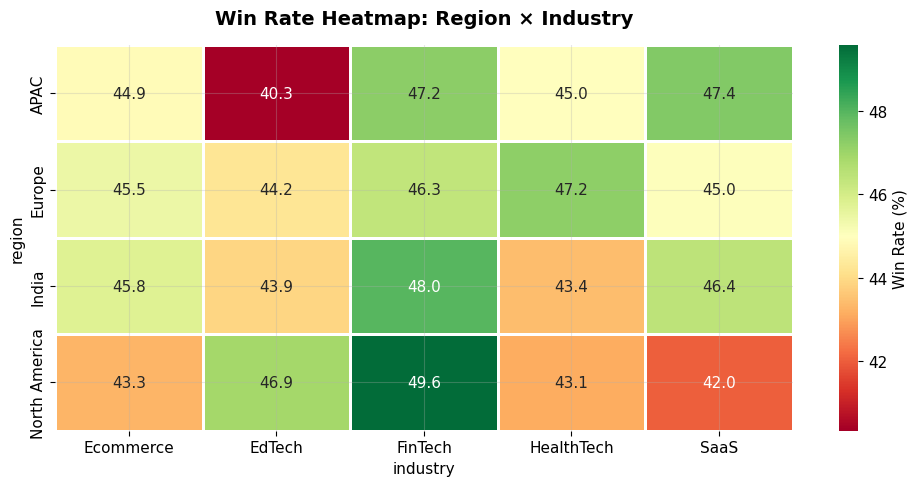

In [17]:
print("\n📊 Chart 8: Region × Industry Win Rate Heatmap")

pivot_heat = df_main.pivot_table(values='won', index='region', columns='industry', aggfunc='mean') * 100

fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(pivot_heat, annot=True, fmt='.1f', cmap='RdYlGn', center=45,
            linewidths=1, ax=ax, cbar_kws={'label': 'Win Rate (%)'})
plt.title('Win Rate Heatmap: Region × Industry', pad=15)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/08_heatmap_region_industry.png', dpi=150, bbox_inches='tight')


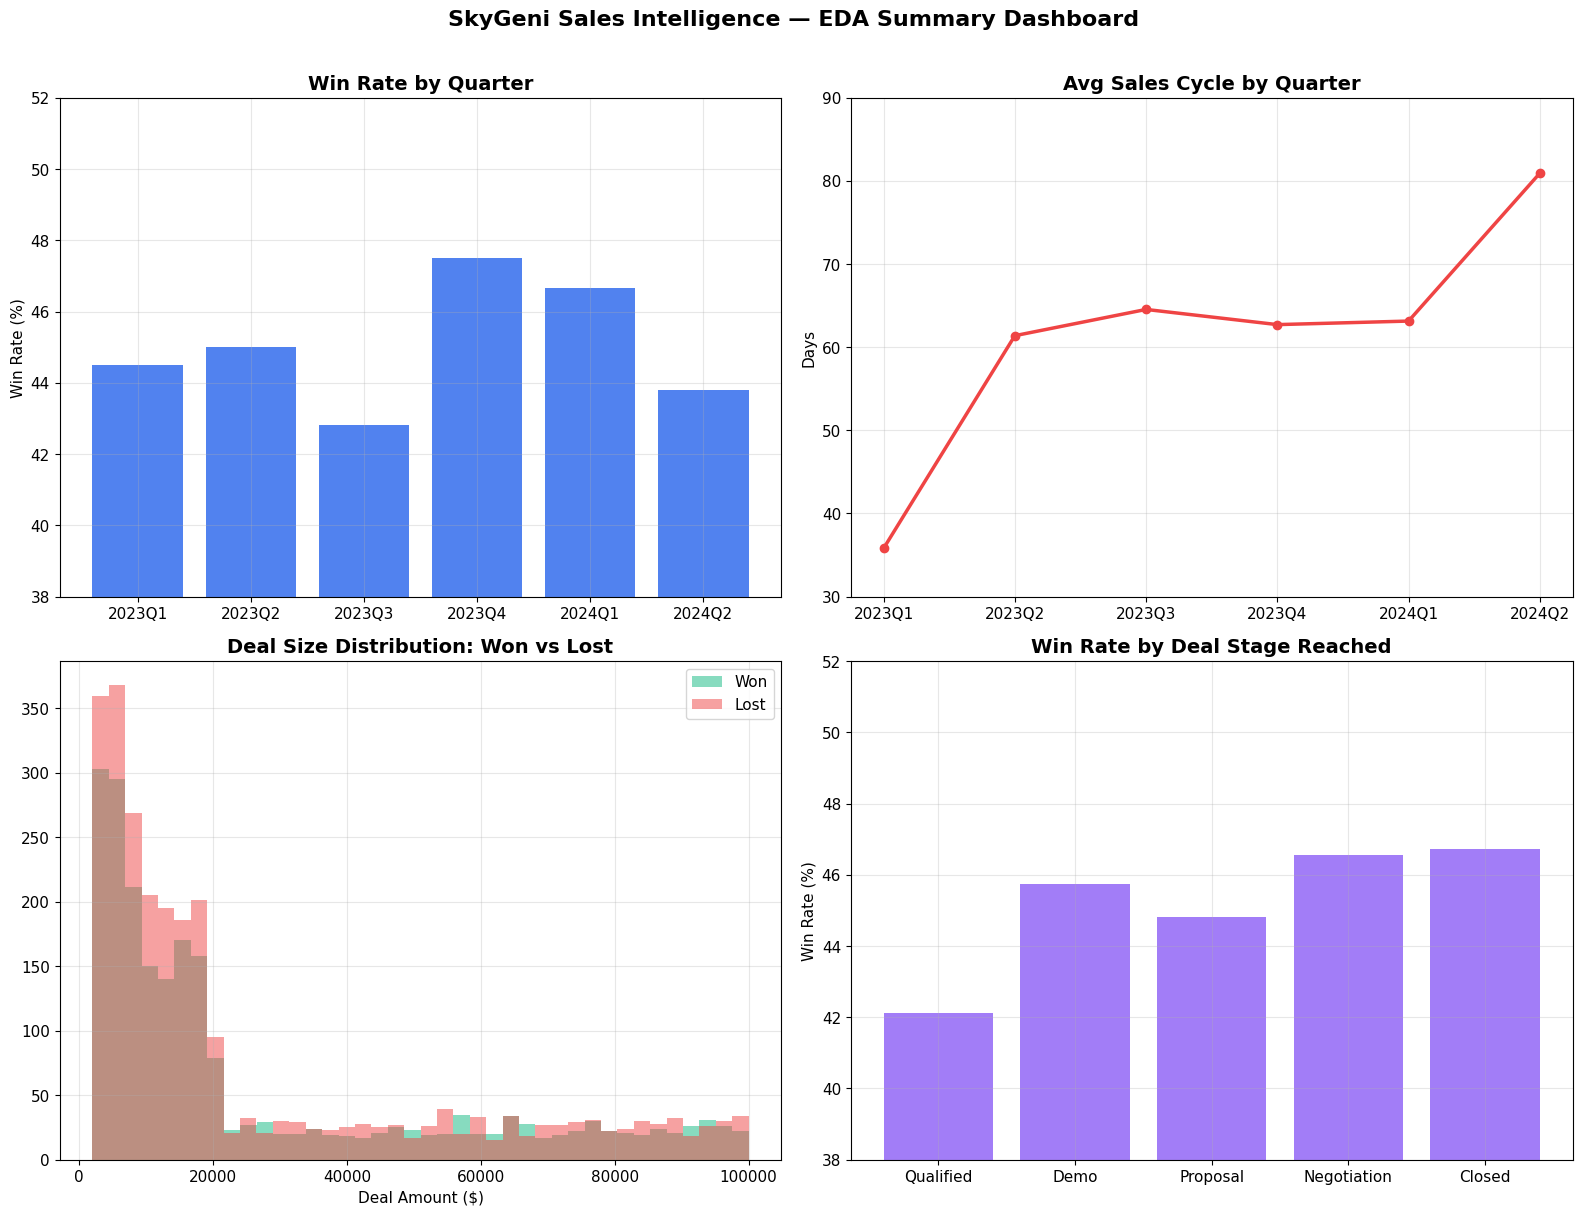

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top-left: Win rate by quarter
axes[0, 0].bar(q_summary.index, q_summary['win_rate'] * 100, color=COLORS[0], alpha=0.8)
axes[0, 0].set_title('Win Rate by Quarter')
axes[0, 0].set_ylabel('Win Rate (%)')
axes[0, 0].set_ylim(38, 52)

# Top-right: Avg sales cycle by quarter
axes[0, 1].plot(q_summary.index, q_summary['avg_cycle'], color=COLORS[3], marker='o', linewidth=2.5)
axes[0, 1].set_title('Avg Sales Cycle by Quarter')
axes[0, 1].set_ylabel('Days')
axes[0, 1].set_ylim(30, 90)

# Bottom-left: Deal size distribution (won vs lost)
for outcome, color in [('Won', COLORS[2]), ('Lost', COLORS[3])]:
    sub = df_main[df_main['outcome'] == outcome]['deal_amount']
    axes[1, 0].hist(sub, bins=40, alpha=0.5, label=outcome, color=color)
axes[1, 0].set_title('Deal Size Distribution: Won vs Lost')
axes[1, 0].set_xlabel('Deal Amount ($)')
axes[1, 0].legend()

# Bottom-right: Win rate by deal stage
stage_order = ['Qualified', 'Demo', 'Proposal', 'Negotiation', 'Closed']
stage_wr = df_main.groupby('deal_stage')['won'].mean().reindex(stage_order)
axes[1, 1].bar(stage_wr.index, stage_wr.values * 100, color=COLORS[4], alpha=0.8)
axes[1, 1].set_title('Win Rate by Deal Stage Reached')
axes[1, 1].set_ylabel('Win Rate (%)')
axes[1, 1].set_ylim(38, 52)

plt.suptitle('SkyGeni Sales Intelligence — EDA Summary Dashboard', fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/09_summary_dashboard.png', dpi=150, bbox_inches='tight')

